<a href="https://colab.research.google.com/github/ReidelVichot/DEFreightProfiles/blob/main/Roads_Tracks_infograph%208-06-24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
!pip install contextily
import contextily as cx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 47.7 MB/s eta 0:00:00


#Freight Corridor Infograph

In [ ]:
dir = "/content/drive/MyDrive/FreightProfiles/"

# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")
# Import tracks from google drive
# Source: Fist Maps
# https://de-firstmap-delaware.hub.arcgis.com/datasets/railroad-rail-lines/explore?location=39.655622%2C-75.765561%2C13.56
rail_name = "Delaware_Multimodal_2.0_tracks/Delaware_Multimodal_2.0.shp"
rail = gpd.read_file(dir + rail_name)
rail = rail.to_crs("EPSG:2235")
cols = ['NAME','geometry']
ccd = ccd[cols]
cols = ['TRACK_TYPE', 'STATUS', 'LINE_ID', 'OWNER', 'geometry']
rail = rail[cols]

taz_name = "/content/drive/MyDrive/temp_dstep23/TAZ_analysis/DE_TAZ_2021_TRKGEN_region.shp"
taz = gpd.read_file(taz_name)
taz = taz.to_crs("EPSG:2235")

taz["FIS"] = taz['NATRES_20'] + taz['CONS_20'] + taz['MANU_20'] + taz['TRN_UTL_20'] + taz['WHL_RET_20'] + taz['FOOD_SVC_2']
taz["SIS"] = taz['OT_SVCS_20'] + taz['ED_HEALTH_'] + taz['FINANCE_20'] + taz['PRO_BUS_20'] + taz['LE_HOSP_20'] + taz['INFO_20']
taz["FIS_per"] = taz["FIS"]/taz['TOT_20']*100
taz_grpd = taz.groupby("CCD").sum(numeric_only = True)
taz_grpd["FIS_per"] = taz_grpd["FIS"]/taz_grpd["TOT_20"]*100
taz_grpd["FIS_capita"] = taz_grpd["FIS"]/taz_grpd["POP_20"]
taz_grpd.reset_index(inplace=True)
taz_grpd.at[ 9, "CCD"] = "Lower Christiana"
taz_grpd.at[25, "CCD"] = "Upper Christiana"
taz_grpd.at[12, "CCD"] = "Middletown-Odessa"
taz_grpd.at[20, "CCD"] = "Pike Creek-Central Kirkwood"
ccd = ccd.merge(taz_grpd, left_on="NAME", right_on="CCD")

CFC = gpd.read_file(dir + "Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0 (1)/Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0.shp")
CFC = CFC.to_crs("EPSG:2235")

#Freight Movement Bottlenecks
FMB = gpd.read_file(dir + "FreightMovementBottlenecks/Delaware_Multimodal_2.0.shp")
FMB = FMB.to_crs("EPSG:2235")

CoastalCorridor = gpd.read_file(dir + "CoastalCorridor/Delaware_Multimodal_2.0.shp")
CoastalCorridor = CoastalCorridor.to_crs("EPSG:2235")

MetroCorridor = gpd.read_file(dir + "MetroCorridor/Delaware_Multimodal_2.0.shp")
MetroCorridor = MetroCorridor.to_crs("EPSG:2235")

LewesCorridor = gpd.read_file(dir + "LewesCorridor/Delaware_Multimodal_2.0.shp")
LewesCorridor = LewesCorridor.to_crs("EPSG:2235")

BayCorridor = gpd.read_file(dir + "BayCorridor/Delaware_Multimodal_2.0.shp")
BayCorridor = BayCorridor.to_crs("EPSG:2235")

PiedmontCorridor = gpd.read_file(dir + "PiedmontCorridor/Delaware_Multimodal_2.0.shp")
PiedmontCorridor = PiedmontCorridor.to_crs("EPSG:2235")

land = gpd.read_file("/content/drive/MyDrive/FreightProfiles/2022_Land_Use_Land_Cover (1)/2022_Land_Use_Land_Cover.shp")
land = land.to_crs("EPSG:2235")
cols = ["LULC_CATEG", "geometry"]
land = land[cols]
land = land[land.LULC_CATEG == "Cropland"]
land_ccd = gpd.overlay(land, ccd, how="intersection")[["NAME", "LULC_CATEG", "geometry"]]
land_ccd["AgLand_acres"] = land_ccd.area*2.29568e-5
ag_land = land_ccd.groupby("NAME").sum(numeric_only=True).reset_index()

ccd = ccd.merge(ag_land, on="NAME", how="left")

In [ ]:
truck_traffic = pd.read_csv(dir + "StreetLight/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020_odg_comm.csv")
cols = ['Vehicle Weight', 'Origin Zone ID', 'Origin Zone Name',
        'Origin Zone Source', 'Destination Zone ID', 'Destination Zone Name',
        'Destination Zone Source', 'Day Type', 'Day Part',
        'Average Daily O-D Traffic (StL Index)',
        'Average Daily Origin Zone Traffic (StL Index)',
       'Average Daily Destination Zone Traffic (StL Index)',
       'Avg Travel Time (sec)']
truck_traffic = truck_traffic[cols]
truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()
truck_traffic_ccd = truck_traffic2[truck_traffic2["Destination Zone Name"].isin(ccd["NAME"].values)][['Destination Zone Name', 'Average Daily O-D Traffic (StL Index)']]
ccd  = ccd.merge(truck_traffic_ccd, left_on="CCD", right_on="Destination Zone Name", how="left")
ccd["z-score"] = (ccd["Average Daily O-D Traffic (StL Index)"] - ccd["Average Daily O-D Traffic (StL Index)"].mean())/ccd["Average Daily O-D Traffic (StL Index)"].std()

<ipython-input-159-00d5e9eaa0f9>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()


In [ ]:
truck_parking_name =  dir + "DE_Undesig_Clusters/DE_Undesig_Clusters/Delaware_Undesig_Clusters.shp"
truck_parking =  gpd.read_file(truck_parking_name)
truck_parking = truck_parking.to_crs("EPSG:2235")
truck_parking["Parking"] = "Truck Parking"

In [ ]:
# Original
#CCD = "Dover"
#resol = 85000
#x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
#x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
#y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
#y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol

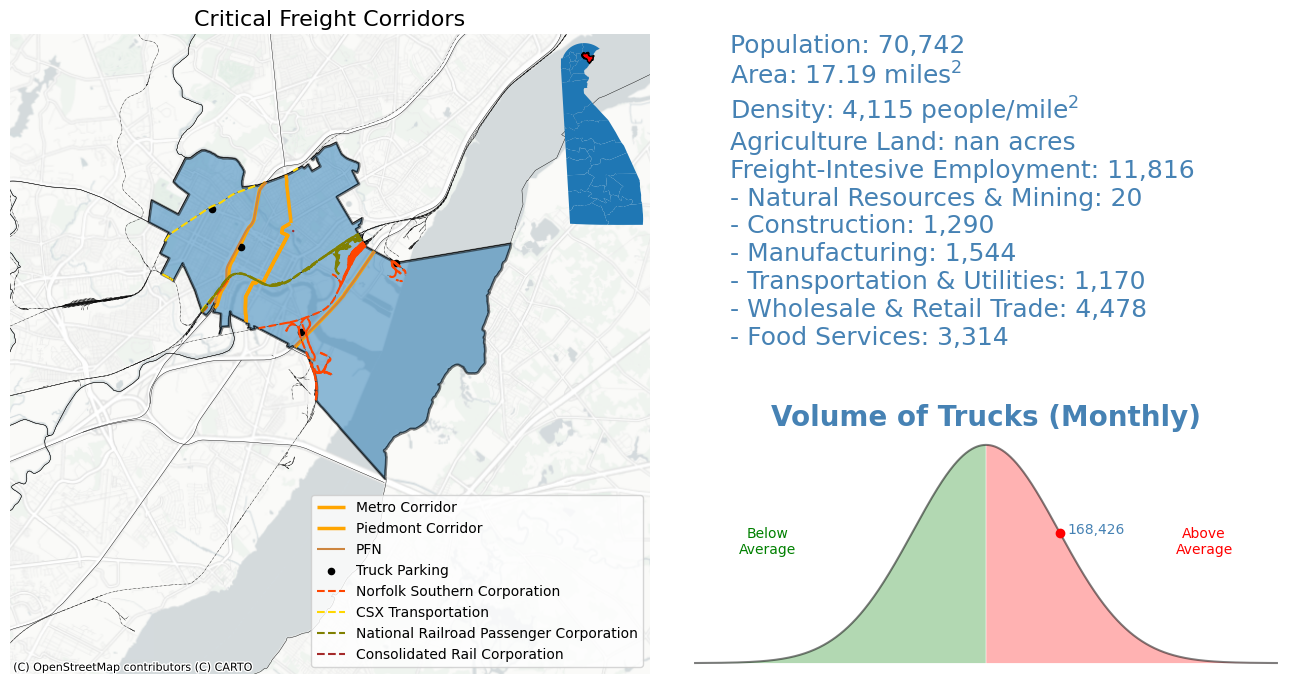

In [ ]:
import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")


CCD = "Wilmington"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol  - 6000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 6000



font = {'color':  'black',
        'weight': 'normal',
        'size': 16}
# [left, bottom, width, height]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0.05, 0.05, 0.4, 0.8])

plt.title("Critical Freight Corridors", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
CFC.plot(color="k", linestyle="-", lw = 0.3, ax=ax)
metro_intercept = gpd.overlay(MetroCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
metro_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Metro Corridor', color="orange",
                             zorder=1);
piedmont_intercept = gpd.overlay(PiedmontCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
piedmont_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Piedmont Corridor', color="orange",
                             zorder=1);
bay_intercept = gpd.overlay(BayCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
bay_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Bay Corridor', color="orange",
                             zorder=1);
lewes_intercept = gpd.overlay(LewesCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
lewes_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Lewes Corridor', color="orange",
                             zorder=1);
coastal_intercept = gpd.overlay(CoastalCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
coastal_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Coastal Corridor', color="wheat",
                             zorder=1);
intersept = gpd.overlay(CFC, ccd[ccd["NAME"]==CCD], how="intersection")

intersept[intersept["FREIGHT_NE"]=='CUFC'].plot(linestyle="-", ax=ax,
                             label = 'CUFC', color="steelblue");
intersept[intersept["FREIGHT_NE"]== 'CRFC'].plot(linestyle="-", ax=ax,
                             label = 'CRFC', color="darkgreen");
intersept[intersept["FREIGHT_NE"]== 'PFN'].plot(linestyle="-", ax=ax,
                             label = 'PFN', color="peru");
bottleneck_intersect = gpd.overlay(FMB, ccd[ccd["NAME"]==CCD], how="intersection")
bottleneck_intersect.plot("ROADNAME", linestyle="-", ax=ax,
                             label = "Bottleneck", color="red");
rail.plot(color="k", linestyle="-.", lw = 0.3, ax=ax)


truck_parking_intercept = gpd.overlay(truck_parking, ccd[ccd["NAME"]==CCD], how="intersection")
truck_parking_intercept.geometry.centroid.plot(color="k", markersize=20, ax=ax, label="Truck Parking", zorder=1)
ax.legend(loc='lower right')


palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

for i in range(len(rail["OWNER"].unique())):
  intersect_rail = gpd.overlay(rail[rail.OWNER==rail["OWNER"].unique()[i]], ccd[ccd["NAME"]==CCD], how="intersection");
  intersect_rail.plot("OWNER", linestyle="--", ax=ax, label = rail["OWNER"].unique()[i], color = palette[i]);

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

ax2 = fig.add_axes([0.37, 0.60, 0.1, 0.25])
ccd.plot(ax=ax2)
ccd[ccd['NAME'] == CCD].plot(ax=ax2, color="r", edgecolor="k", lw = 1)
ax2.set_axis_off()

ax3 = fig.add_axes([0.460, 0.40, 0.4, 0.45])
ax3.set_axis_off()

ax4 = fig.add_axes([0.460, 0.05, 0.4, 0.3])
# prompt: plot a bell curve
# Define the x-axis values
x = np.linspace(-4, 4, 1000)
# Define the y-axis values using the normal distribution function
y = np.exp(-x**2 / 2) / (np.sqrt(2 * np.pi))
# The z-score
z = ccd[ccd["NAME"]==CCD]["z-score"].values[0]

# Create the plot
ax4.plot(x, y, alpha=0.5, color="k")

# Add labels and title
ax4.set_axis_off()
plt.title("Volume of Trucks (Monthly)", color="steelblue", weight="bold", fontsize=20)

# Add a dot on the bell curve at x = 1
ax4.plot(z, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), marker="o", color="red")
if z > 0:
  ax4.text(z+0.1, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["Average Daily O-D Traffic (StL Index)"].values[0]), color="steelblue", ha="left")
else:
  ax4.text(z-0.1, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["Average Daily O-D Traffic (StL Index)"].values[0]), color="steelblue", ha="right")
# Fill the area under the curve with green color
ax4.fill_between(x, y, 0, where=x <= 0, facecolor="green", alpha=0.3)
ax4.fill_between(x, y, 0, where=x > 0, facecolor="red", alpha=0.3)
ax4.text(-3,0.2, "Below\nAverage", color="green", alpha=1, fontsize=10, ha="center")
ax4.text( 3,0.2, "Above\nAverage", color="red", alpha=1, fontsize=10, ha="center")

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')

#header = fig.text(0.5, 0.90, "Freight Profile: " + CCD, fontsize=20, color="k", weight="bold", ha="center")
content =  fig.text(0.5, 0.85,  "Population: " +  "{:,}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0]) + "\n" +
                                "Area: " + "{:,.2f}".format(ccd[ccd["NAME"]==CCD].area.values[0]*3.58701e-8) + " miles$^2$\n" +
                                "Density: " + "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0] / ccd[ccd["NAME"]==CCD].area.values[0] / 3.58701e-8) + " people/mile$^2$\n" +
                                "Agriculture Land: " + "{:,.0f} acres".format(ccd[ccd["NAME"]==CCD]['AgLand_acres'].values[0]) + "\n" +
                                "Freight-Intesive Employment: " + "{:,}".format(ccd[ccd["NAME"]==CCD]["FIS"].values[0]) + "\n" +
                                "- Natural Resources & Mining: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['NATRES_20'].values[0]) + "\n" +
                                "- Construction: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['CONS_20'].values[0]) + "\n" +
                                "- Manufacturing: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['MANU_20'].values[0]) + "\n" +
                                "- Transportation & Utilities: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['TRN_UTL_20'].values[0]) + "\n" +
                                "- Wholesale & Retail Trade: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['WHL_RET_20'].values[0]) + "\n"
                                "- Food Services: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['FOOD_SVC_2'].values[0]) + "\n"
                                , color="steelblue", weight="normal", va="top", fontsize=18)
fig.show()

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd2 =  gpd.read_file(dir + ccd_name)[["NAME", "geometry"]]
ccd2 = ccd2.to_crs("EPSG:2235")
truck_parking_temp = gpd.overlay(truck_parking, ccd2, how="intersection")
temp1 = truck_parking_temp.groupby("NAME").sum(numeric_only=True).reset_index()
temp2 = truck_parking_temp.groupby("NAME").count().reset_index()[["NAME", "Parking"]]
parking = temp1.merge(temp2, on="NAME")

ccd_updated = ccd.merge(parking, on="NAME", how="left")

In [ ]:
CFC_ccd = gpd.overlay(CFC, ccd, how="intersection")
CFC_ccd["length_CFC"] = CFC_ccd.length
CFC_ccd = CFC_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_CFC"]]

PiedmontCorridor_ccd = gpd.overlay(PiedmontCorridor, ccd, how="intersection", keep_geom_type=True)
PiedmontCorridor_ccd["length_Piedmont"] = PiedmontCorridor_ccd.length
PiedmontCorridor_ccd = PiedmontCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Piedmont"]]

CoastalCorridor_ccd = gpd.overlay(CoastalCorridor, ccd, how="intersection", keep_geom_type=True)
CoastalCorridor_ccd["length_Coastal"] = CoastalCorridor_ccd.length
CoastalCorridor_ccd = CoastalCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Coastal"]]

MetroCorridor_ccd = gpd.overlay(MetroCorridor, ccd, how="intersection", keep_geom_type=True)
MetroCorridor_ccd["length_Metro"] = MetroCorridor_ccd.length
MetroCorridor_ccd = MetroCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Metro"]]

#--- Empty
LewesCorridor_ccd = gpd.overlay(LewesCorridor, ccd, how="intersection", keep_geom_type=True)
LewesCorridor_ccd["length_Lewes"] = LewesCorridor_ccd.length
LewesCorridor_ccd = LewesCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Lewes"]]

BayCorridor_ccd = gpd.overlay(BayCorridor, ccd, how="intersection", keep_geom_type=True)
BayCorridor_ccd["length_Bay"] = BayCorridor_ccd.length
BayCorridor_ccd = BayCorridor_ccd.groupby("NAME").sum(numeric_only=True).reset_index()[["NAME","length_Bay"]]

ccd = ccd.merge(CFC_ccd, on="NAME", how="left").fillna(0)
ccd = ccd.merge(PiedmontCorridor_ccd, on="NAME", how="left").fillna(0)
ccd = ccd.merge(CoastalCorridor_ccd, on="NAME", how="left").fillna(0)
ccd = ccd.merge(MetroCorridor_ccd, on="NAME", how="left").fillna(0)
# Empty
#ccd = ccd.merge(LewesCorridor_ccd, left_on="CCD", right_on="NAME", how="left")
ccd = ccd.merge(BayCorridor_ccd, on="NAME", how="left").fillna(0)

# Before remove Lewes Corridor
#ccd["freight_length"] = ccd["length_CFC"] + ccd["length_Piedmont"] + ccd["length_Coastal"] + ccd["length_Metro"] + ccd["length_Lewes"] + ccd["length_Bay"]
ccd["freight_length"] = ccd["length_CFC"] + ccd["length_Piedmont"] + ccd["length_Coastal"] + ccd["length_Metro"] + ccd["length_Bay"]

ccd = ccd.drop(columns=["NAME"])

rail_ccd = gpd.overlay(rail, ccd, how="intersection", keep_geom_type=True)
rail_ccd["rail_length"] = rail_ccd.length
rail_ccd = rail_ccd.groupby("CCD").sum(numeric_only=True).reset_index()[["CCD","rail_length"]]

ccd = ccd.merge(rail_ccd, on="CCD", how="left").fillna(0)

# Adding parking values
dir = "/content/drive/MyDrive/FreightProfiles/"
truck_parking_name =  dir + "DE_Undesig_Clusters/DE_Undesig_Clusters/Delaware_Undesig_Clusters.shp"
truck_parking =  gpd.read_file(truck_parking_name)
truck_parking = truck_parking.to_crs("EPSG:2235")
#truck_parking["geometry"] = truck_parking.centroid

truck_parking_ccd = gpd.overlay(truck_parking, ccd[["CCD","geometry"]], how="intersection")

count_parking = truck_parking_ccd.groupby("CCD").count()[["geometry"]].reset_index()
count_parking.columns = ["CCD","count_parking"]
count_spots = truck_parking_ccd.groupby("CCD").sum(numeric_only=True).reset_index()
count_spots.columns = ["CCD","count_spots"]
ccd = ccd.merge(count_parking, on="CCD", how="left").fillna(0)
ccd = ccd.merge(count_spots, on="CCD", how="left").fillna(0)

ccd.rename(columns={"Average Daily O-D Traffic (StL Index)":"StL_Index"}, inplace=True)

In [ ]:
truck_parking_ccd.sort_values("CCD")

In [ ]:
ccd_x =  gpd.read_file(dir + ccd_name)
ccd_x = ccd_x.to_crs("EPSG:2235")
ccd_x = ccd_x[["NAME", "geometry"]]
ccd_x.columns = ["CCD", "geometry"]
cols = ['DESCRIPTIO', 'NAME', 'MILES', 'ROADNUMBER', 'ROADNAME', 'TRUCK_PERC', 'geometry']

FMB_reduced = FMB[cols]
gpd.overlay(FMB_reduced, ccd_x, how="intersection").sort_values("CCD")

In [ ]:
gpd.overlay(FMB_reduced, ccd_x, how="intersection").sort_values("CCD").length * 0.00018939393935722

In [ ]:
# -- import statmodels using the formula api
import statsmodels.formula.api as sm

# -- first build the model
model = sm.ols("StL_Index ~ AgLand_acres + FIS + count_parking + freight_length", data=ccd)

# -- now fit the model to the data
result = model.fit()

# -- summarize the model fit
print(result.summary())

#Land Use

In [4]:
dir = "/content/drive/MyDrive/FreightProfiles/"
# land use file 2022
land_use_22 = gpd.read_file(dir + "2022_Land_Use_Land_Cover (1)/2022_Land_Use_Land_Cover.shp")
land_use_22 = land_use_22.to_crs("EPSG:2235")
# land use file 2017
land_use_17 = gpd.read_file(dir + "2017_Delaware_Landuse_Landcover_Multiple_Years_/Delaware_Landuse_Landcover_Multiple_Years_.shp")
land_use_17 = land_use_17.to_crs("EPSG:2235")
# land use file 2012
land_use_12 = gpd.read_file(dir + "2012_Land_Use_Land_Cover/2012_Land_Use_Land_Cover.shp")
land_use_12 = land_use_12.to_crs("EPSG:2235")
# land use file 2007
land_use_07 = gpd.read_file(dir + "2007_Delaware_Landuse_Landcover_Multiple_Years_/Delaware_Landuse_Landcover_Multiple_Years_.shp")
land_use_07 = land_use_07.to_crs("EPSG:2235")
# select columns of interest
cols = ['LULC_CATEG', 'geometry']
land_use_22 = land_use_22[cols]
land_use_17 = land_use_17[cols]
land_use_12 = land_use_12[cols]
land_use_07 = land_use_07[cols]

# Agricultural-related categories for land_use_22
x1  = land_use_22["LULC_CATEG"] == "Clear-cut"
x2  = land_use_22["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_22["LULC_CATEG"] == "Cropland"
x4  = land_use_22["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_22["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_22["LULC_CATEG"] == "Idle Fields"
x7  = land_use_22["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_22["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_22["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_22["LULC_CATEG"] == "Pasture"
x11 = land_use_22["LULC_CATEG"] == "Shrub/Brush Rangeland"

land_use_22 = land_use_22[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

# Agricultural-related categories for land_use_17
x1  = land_use_17["LULC_CATEG"] == "Clear-cut"
x2  = land_use_17["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_17["LULC_CATEG"] == "Cropland"
x4  = land_use_17["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_17["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_17["LULC_CATEG"] == "Idle Fields"
x7  = land_use_17["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_17["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_17["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_17["LULC_CATEG"] == "Pasture"
x11 = land_use_17["LULC_CATEG"] == "Shrub/Brush Rangeland"

# Now filter land_use_17 using the correct masks
land_use_17 = land_use_17[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

# Agricultural-related categories for land_use_12
x1  = land_use_12["LULC_CATEG"] == "Clear-cut"
x2  = land_use_12["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_12["LULC_CATEG"] == "Cropland"
x4  = land_use_12["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_12["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_12["LULC_CATEG"] == "Idle Fields"
x7  = land_use_12["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_12["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_12["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_12["LULC_CATEG"] == "Pasture"
x11 = land_use_12["LULC_CATEG"] == "Shrub/Brush Rangeland"

# Now filter land_use_12 using the correct masks
land_use_12 = land_use_12[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

# Agricultural-related categories for land_use_07
x1  = land_use_07["LULC_CATEG"] == "Clear-cut"
x2  = land_use_07["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_07["LULC_CATEG"] == "Cropland"
x4  = land_use_07["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_07["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_07["LULC_CATEG"] == "Idle Fields"
x7  = land_use_07["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_07["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_07["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_07["LULC_CATEG"] == "Pasture"
x11 = land_use_07["LULC_CATEG"] == "Shrub/Brush Rangeland"

# Now filter land_use_07 using the correct masks
land_use_07 = land_use_07[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

land_use_22["AgAcres"] = land_use_22.area * 2.295686400367e-5
land_use_17["AgAcres"] = land_use_17.area * 2.295686400367e-5
land_use_12["AgAcres"] = land_use_12.area * 2.295686400367e-5
land_use_07["AgAcres"] = land_use_07.area * 2.295686400367e-5

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [5]:
# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")

In [6]:
land_use_22 = gpd.overlay(land_use_22, ccd[["NAME","geometry"]], how="intersection")
land_use_17 = gpd.overlay(land_use_17, ccd[["NAME","geometry"]], how="intersection")
land_use_12 = gpd.overlay(land_use_12, ccd[["NAME","geometry"]], how="intersection")
land_use_07 = gpd.overlay(land_use_07, ccd[["NAME","geometry"]], how="intersection")

<Axes: xlabel='LULC_CATEG'>

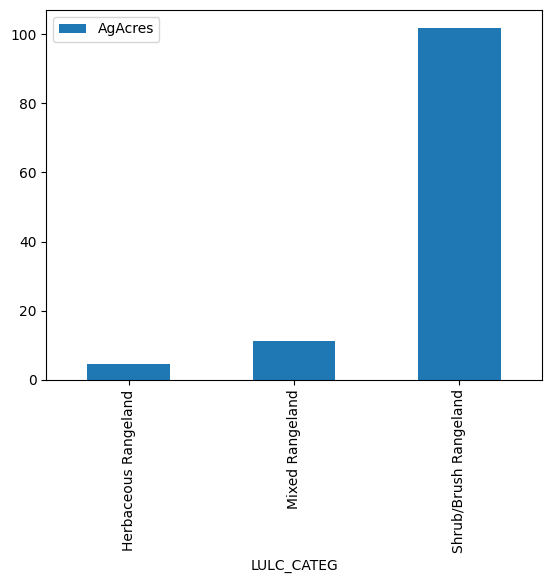

In [7]:
land_use_22[land_use_22.NAME=="Wilmington"].groupby("LULC_CATEG").sum(numeric_only=True).plot(kind="bar")

In [8]:
x_22 = land_use_22.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_22.rename(columns={"AgAcres":"2022"}, inplace=True)
x_17 = land_use_17.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_17.rename(columns={"AgAcres":"2017"}, inplace=True)
x_12 = land_use_12.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_12.rename(columns={"AgAcres":"2012"}, inplace=True)
x_07 = land_use_07.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_07.rename(columns={"AgAcres":"2007"}, inplace=True)

land_use = x_22.merge(x_17, on=["NAME","LULC_CATEG"], how="left")
land_use = land_use.merge(x_12, on=["NAME","LULC_CATEG"], how="left")
land_use = land_use.merge(x_07, on=["NAME","LULC_CATEG"], how="left")

In [9]:
land_use

2022  \
NAME             LULC_CATEG                                          
Brandywine       Cropland                               510.198612   
                 Farmsteads and Farm Related Buildings    7.682222   
                 Herbaceous Rangeland                    40.648480   
                 Idle Fields                             12.515345   
                 Mixed Rangeland                         18.298156   
...                                                            ...   
Upper Christiana Orchards/Nurseries/Horticulture          3.569980   
                 Shrub/Brush Rangeland                  111.338503   
Wilmington       Herbaceous Rangeland                     4.399345   
                 Mixed Rangeland                         11.248981   
                 Shrub/Brush Rangeland                  101.977072   

                                                              2017  \
NAME             LULC_CATEG                                          
Brandywine       Cropland                               513.488888   
                 Farmsteads and Farm Related Buildings    5.640014   
                 Herbaceous Rangeland                    37.367822   
                 Idle Fields                             12.506423   
                 Mixed Rangeland                         18.257021   
...                                                            ...   
Upper Christiana Orchards/Nurseries/Horticulture          3.570182   
                 Shrub/Brush Rangeland                  111.383449   
Wilmington       Herbaceous Rangeland                     1.875437   
                 Mixed Rangeland                         11.233272   
                 Shrub/Brush Rangeland                  104.609981   

                                                              2012        2007  
NAME             LULC_CATEG                                                     
Brandywine       Cropland                               534.066836  595.923309  
                 Farmsteads and Farm Related Buildings   17.322051   17.322050  
                 Herbaceous Rangeland                    51.153639   46.804128  
                 Idle Fields                             42.697526   17.716429  
                 Mixed Rangeland                         42.677198   41.615052  
...                                                            ...         ...  
Upper Christiana Orchards/Nurseries/Horticulture          3.570182         NaN  
                 Shrub/Brush Rangeland                   79.308468  144.988645  
Wilmington       Herbaceous Rangeland                          NaN         NaN  
                 Mixed Rangeland                         22.974004   19.309824  
                 Shrub/Brush Rangeland                   77.790663   93.538934  

[256 rows x 4 columns]

In [10]:
x_22 = x_22.reset_index()
x_17 = x_17.reset_index()
x_12 = x_12.reset_index()
x_07 = x_07.reset_index()

In [11]:
CCD = "Wilmington"
resol = 20000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1459: UserWarn

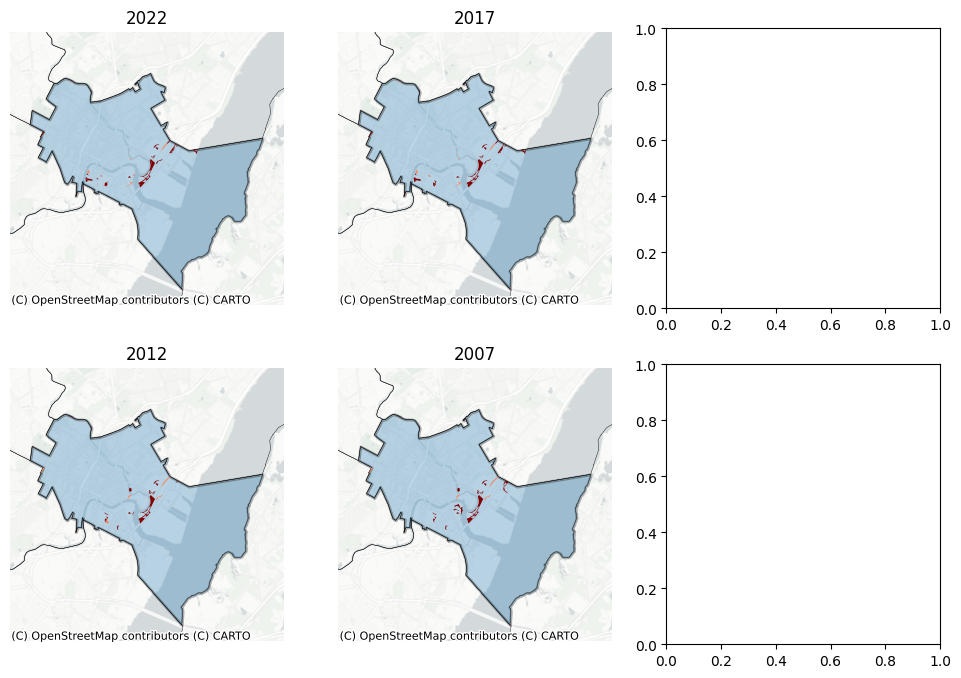

In [12]:
import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")

fig, ax = plt.subplots(2,3, figsize=(12, 8))
axis_i = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
years = [2022, 2017, 2012, 2007]
palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

for i in range(4):
  xx = str(years)[2:]
  axis = axis_i[i]

  axis.set_title(str(years[i]))
  ccd.plot(facecolor = "none", lw = 0.3, ax=axis)
  ccd[ccd["NAME"]==CCD].plot(alpha=0.3, edgecolor="k", lw = 2 , ax=axis)

  xx = str(years[i])[2:]
  x = globals()["land_use_" + xx]
  x[x.NAME == CCD][x.LULC_CATEG == 'Clear-cut'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[0])
  x[x.NAME == CCD][x.LULC_CATEG == 'Confined Feeding Operations/Feedlots/Holding'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[1])
  x[x.NAME == CCD][x.LULC_CATEG == 'Cropland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[2])
  x[x.NAME == CCD][x.LULC_CATEG == 'Farmsteads and Farm Related Buildings'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[3])
  x[x.NAME == CCD][x.LULC_CATEG == 'Herbaceous Rangeland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[4])
  x[x.NAME == CCD][x.LULC_CATEG == 'Idle Fields'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[5])
  x[x.NAME == CCD][x.LULC_CATEG == 'Mixed Rangeland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[6])
  x[x.NAME == CCD][x.LULC_CATEG == 'Orchards/Nurseries/Horticulture'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[7])
  x[x.NAME == CCD][x.LULC_CATEG == 'Other Agriculture'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[8])
  x[x.NAME == CCD][x.LULC_CATEG == 'Pasture'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[9])
  x[x.NAME == CCD][x.LULC_CATEG == 'Shrub/Brush Rangeland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[10])

  axis.set_xlim(x_low, x_high)
  axis.set_ylim(y_low, y_high)
  axis.set_axis_off()

  cx.add_basemap(axis, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")




fig.show()


In [72]:
land_use_07.groupby("LULC_CATEG").sum(numeric_only=True).reset_index().sort_values("LULC_CATEG")["year"] = 2007


In [20]:
CCD = "Brandywine"
lu_array = [land_use.loc[CCD]["2007"].sum(), land_use.loc[CCD]["2012"].sum(), land_use.loc[CCD]["2017"].sum(), land_use.loc[CCD]["2022"].sum()]


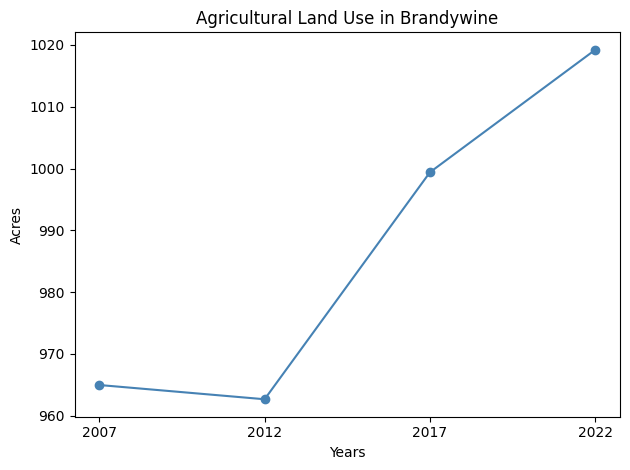

In [42]:
fig, ax = plt.subplots()


ax.plot([2007,2012,2017,2022], lu_array, marker="o", color="steelblue")


ax.set_xlabel("Years")
ax.set_ylabel("Acres")
ax.set_title("Agricultural Land Use in " + CCD)
ax.set_xticks([2007,2012,2017,2022])

fig.tight_layout()
fig.show()

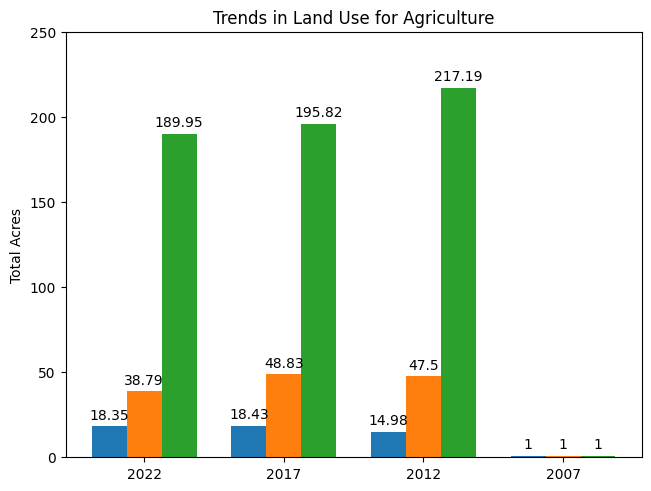

In [68]:
import matplotlib.pyplot as plt
import numpy as np

years = ("2022", "2017", "2012", "2007")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98, 1),
    'Bill Length': (38.79, 48.83, 47.50, 1),
    'Flipper Length': (189.95, 195.82, 217.19, 1),
}

x = np.arange(len(years))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Acres')
ax.set_title('Trends in Land Use for Agriculture')
ax.set_xticks(x + width, years)
ax.set_ylim(0, 250)

plt.show()

#Axle Data

In [ ]:
axle = gpd.read_file(dir + "Data_Axle_2022_DE_point (1)/Data_Axle_2022_DE_point.shp")
axle = axle.to_crs("EPSG:2235")
# simplify columns
cols = ['company', 'address_li', 'city', 'state',
       'zipcode', 'employee_s', 'employee00',
       'sales_volu', 'sales_vo00', 'square_foo',
       'archive_ve', 'archive_00', 'naics_code',
       'primary_na', 'naics8_des', 'geometry']
axle = axle[cols]

axle['naics_code'] = axle['naics_code'].astype(str)
axle['primary_na'] = axle['primary_na'].astype(str)
# Defining Freight-Intensive sectors as in Holguin-Veras 2023
FIS = ('11','21','22','23','31','32','33','42','44','45','48','49','72')
# Selecting only Freight Intensive Sectors
axle = axle[axle['primary_na'].str.startswith(FIS)]

# Converting to the correct data type
axle.zipcode = axle.zipcode.astype(str)
axle.employee_s	 = axle.employee_s.astype(int)
axle.employee00 = axle.employee00.astype(int)
axle.naics_code = axle.sales_volu.astype(str)
axle.primary_na  = axle.primary_na.astype(str)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(se

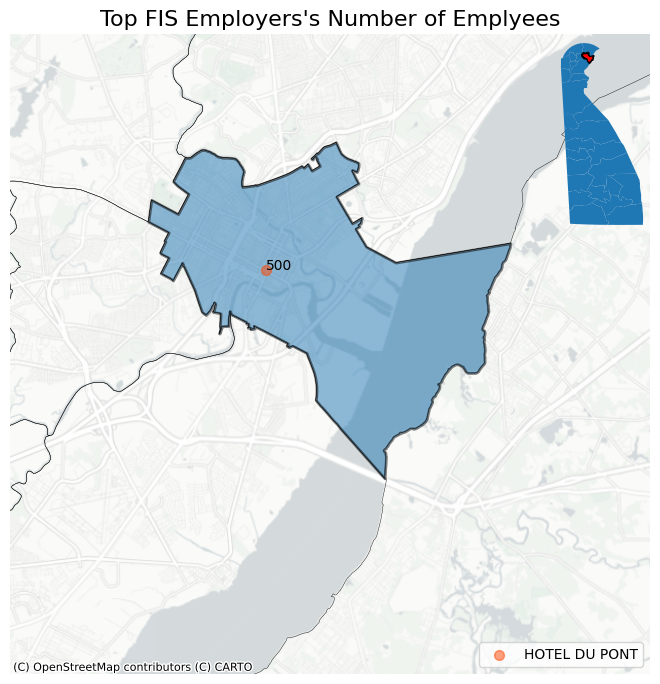

In [ ]:
dir = "/content/drive/MyDrive/FreightProfiles/"

# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")

cols = ['NAME','geometry']
ccd = ccd[cols]

import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")


CCD = "Wilmington"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol  - 6000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 6000


font = {'color':  'black',
        'weight': 'normal',
        'size': 16}
# [left, bottom, width, height]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0.05, 0.05, 0.4, 0.8])

plt.title("Top FIS Employers's Number of Emplyees", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)


axle_high_emp = gpd.overlay(axle[axle["employee_s"] >= 300], ccd[ccd["NAME"]==CCD], how="intersection")

palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

for i in range(len(axle_high_emp)):
  axle_high_emp.iloc[[i]].geometry.centroid.plot(color=palette[i], alpha= 0.5, markersize=axle_high_emp["employee_s"][i]/10, ax=ax, label=axle_high_emp.company[i], zorder=1)
  if (i == 0)&(CCD=="Brandywine"):

    ax.text(axle_high_emp.iloc[[i]].geometry.centroid.x + 40 , axle_high_emp.iloc[[i]].geometry.centroid.y - 1000, "{:,}".format(axle_high_emp["employee_s"][i]), ha="left")
  elif (i == 1)&(CCD=="Milford North"):
    ax.text(axle_high_emp.iloc[[i]].geometry.centroid.x + 20 , axle_high_emp.iloc[[i]].geometry.centroid.y - 1600, "{:,}".format(axle_high_emp["employee_s"][i]), ha="left")

  else: ax.text(axle_high_emp.iloc[[i]].geometry.centroid.x + 40 , axle_high_emp.iloc[[i]].geometry.centroid.y, "{:,}".format(axle_high_emp["employee_s"][i]), ha="left")
ax.legend(loc='lower right')



palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

ax2 = fig.add_axes([0.37, 0.60, 0.1, 0.25])
ccd.plot(ax=ax2)
ccd[ccd['NAME'] == CCD].plot(ax=ax2, color="r", edgecolor="k", lw = 1)
ax2.set_axis_off()

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')

fig.show()

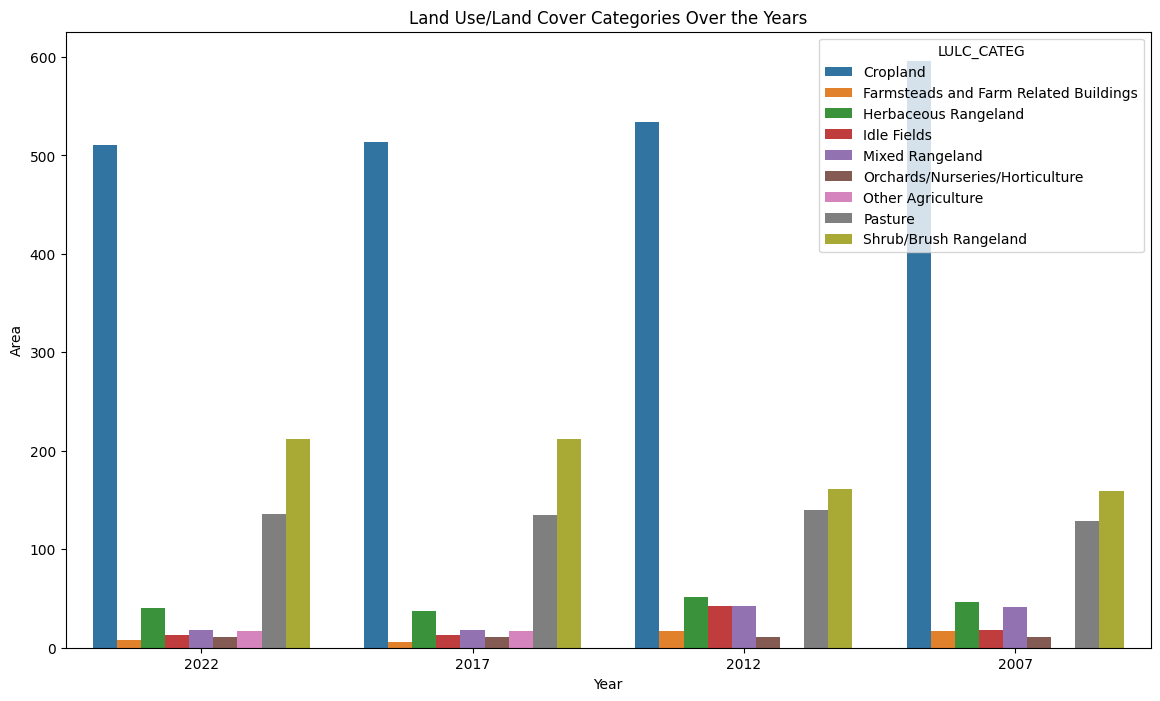

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the DataFrame
data = {
    "LULC_CATEG": ["Cropland", "Farmsteads and Farm Related Buildings", "Herbaceous Rangeland", "Idle Fields", "Mixed Rangeland", "Orchards/Nurseries/Horticulture", "Other Agriculture", "Pasture", "Shrub/Brush Rangeland"],
    "2022": [510.1986123236753, 7.6822218350402895, 40.64848024826517, 12.515344593359057, 18.29815649944554, 10.964262222170378, 17.033321373495568, 135.37460891285625, 212.2618072016608],
    "2017": [513.4888883022967, 5.640014049380056, 37.36782170035305, 12.506422874190712, 18.257021142133922, 10.967349964927411, 17.03892124882954, 134.947886316888, 212.45888667029877],
    "2012": [534.0668360286605, 17.32205058049059, 51.15363930869707, 42.69752634509534, 42.677197655882, 11.088567856159989, None, 139.66051683438823, 160.725691918093],
    "2007": [595.9233093455938, 17.322050006135434, 46.804127618295745, 17.716429037893086, 41.61505245027711, 11.08856721236268, None, 129.2080225700132, 159.5326474897661]
}

df = pd.DataFrame(data)

# Melt the DataFrame to long format
df_melted = df.melt(id_vars=["LULC_CATEG"], var_name="Year", value_name="Value")

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create the bar plot
sns.barplot(data=df_melted, x="Year", y="Value", hue="LULC_CATEG")

# Customize the plot
plt.title("Land Use/Land Cover Categories Over the Years")
plt.ylabel("Area")
plt.xlabel("Year")
#plt.legend(title="LULC Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()